<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.4%20Interest%20Rates/Section%202.4.2.1%20The%20Distribution%20of%20Changes%20in%20Interest%20Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
print("Installing arch...")
!pip install arch 1>/dev/null
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

Installing yfinance and arch...


,Rate,Recession,Year
Date,,,
1954-01-04,1.33,True,1954
1954-01-05,1.28,True,1954
1954-01-06,1.28,True,1954
1954-01-07,1.31,True,1954
1954-01-08,1.31,True,1954
...,...,...,...
2023-03-14,4.71,False,2023
2023-03-15,4.59,False,2023
2023-03-16,4.57,False,2023


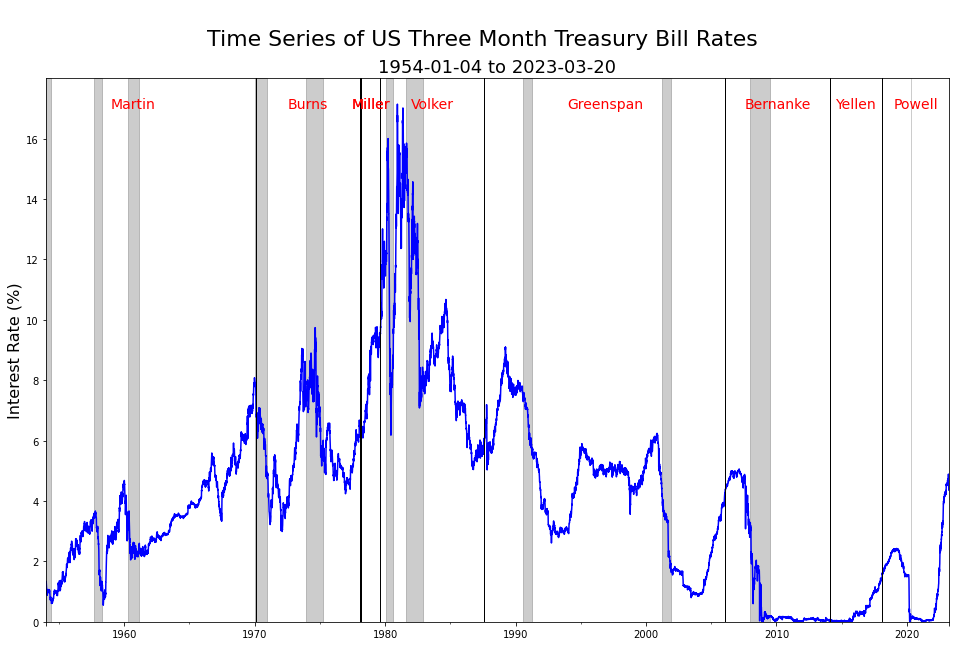

In [152]:
# get the bill rate data from Fred
DTB3=pd.read_table('https://fred.stlouisfed.org/data/DTB3.txt',skiprows=11,sep=r'\s+',header=0).rename(columns={"VALUE":"Rate","DATE":"Date"}).set_index("Date")
DTB3.index=pd.DatetimeIndex(DTB3.index).to_period('D')
DTB3['Rate']=DTB3['Rate'].apply(lambda x:float(x) if x!='.' else np.nan)

# join the recessions data (NBER data at Fred) 
USREC=pd.read_table('https://fred.stlouisfed.org/data/USREC.txt',skiprows=65,sep=r'\s+',header=0).rename(columns={"VALUE":"Recession","DATE":"Date"}).set_index("Date")
USREC.index=pd.DatetimeIndex(USREC.index).to_period('D')
DTB3=DTB3.merge(USREC,left_index=True,right_index=True,how='outer')
DTB3['Recession'].ffill(inplace=True)
DTB3['Recession']=DTB3['Recession'].apply(lambda x:True if x else False)
DTB3.dropna(inplace=True)
DTB3['Year']=DTB3.index.year
DTB3.index=pd.DatetimeIndex(DTB3.index.to_timestamp()).to_period('B') # business days
display(DTB3)

# Figure 2.14
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nTime Series of US Three Month Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
DTB3['Rate'].plot(ax=plot,color='blue')

recbe=list(DTB3.index[DTB3['Recession']!=DTB3['Recession'].shift()])

for b,e in [(k.asfreq(*'MS'),v.asfreq(*'ME')) for k,v in zip(recbe[:-2:2],recbe[1::2])]:
    plot.axvspan(b.to_timestamp(),e.to_timestamp(),color='black',alpha=0.2)

plot.axvspan(recbe[-1].asfreq(*'MS').to_timestamp(),recbe[-1].asfreq(*'ME').to_timestamp(),color='black',alpha=0.2) # above construct doesn't get the COVID recession

for c,b,e in ('Martin','1951-04-02','1970-01-31'),('Burns','1970-02-01','1978-01-31'),('Miller','1978-03-08','1979-08-06'),\
             ('Miller','1978-03-08','1979-08-06'),('Volker','1979-08-06','1987-08-11'),('Greenspan','1987-08-11','2006-01-31'),\
             ('Bernanke','2006-02-01','2014-01-31'),('Yellen','2014-02-03','2018-02-3'),('Powell','2018-02-05',datetime.now()):        
    plot.axvline(b,color='black',lw=1)
    plot.axvline(e,color='black',lw=1)
    m=pd.Timestamp(b)+pd.Timedelta(days=(pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    if m<DTB3.index[0].to_timestamp():
        b=DTB3.index[0].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    elif m>DTB3.index[-1].to_timestamp():
        b=DTB3.index[-1].to_timestamp()
        m=pd.Timestamp(b)+pd.Timedelta((pd.Timestamp(e)-pd.Timestamp(b)).days/two)

    plot.text(m,17,c,fontsize=14,horizontalalignment='center',color='red')
    
plot.set_xlabel(None)
plot.set_ylabel('Interest Rate (%)',fontsize=16)
plot.set_ylim(zero,None);

,Rate,Recession,Year,Change,Volatility,Innovations
Date,,,,,,
1954-01-12,1.30,True,1954,-0.03,0.037377,-0.802642
1954-01-13,1.30,True,1954,0.00,0.036774,0.000000
1954-01-14,1.28,True,1954,-0.02,0.035037,-0.570819
1954-01-15,1.20,True,1954,-0.08,0.033941,-2.357014
1954-01-18,1.20,True,1954,0.00,0.040561,0.000000
...,...,...,...,...,...,...
2023-03-14,4.71,False,2023,0.01,0.052993,0.188706
2023-03-15,4.59,False,2023,-0.12,0.050562,-2.373306
2023-03-16,4.57,False,2023,-0.02,0.060557,-0.330268


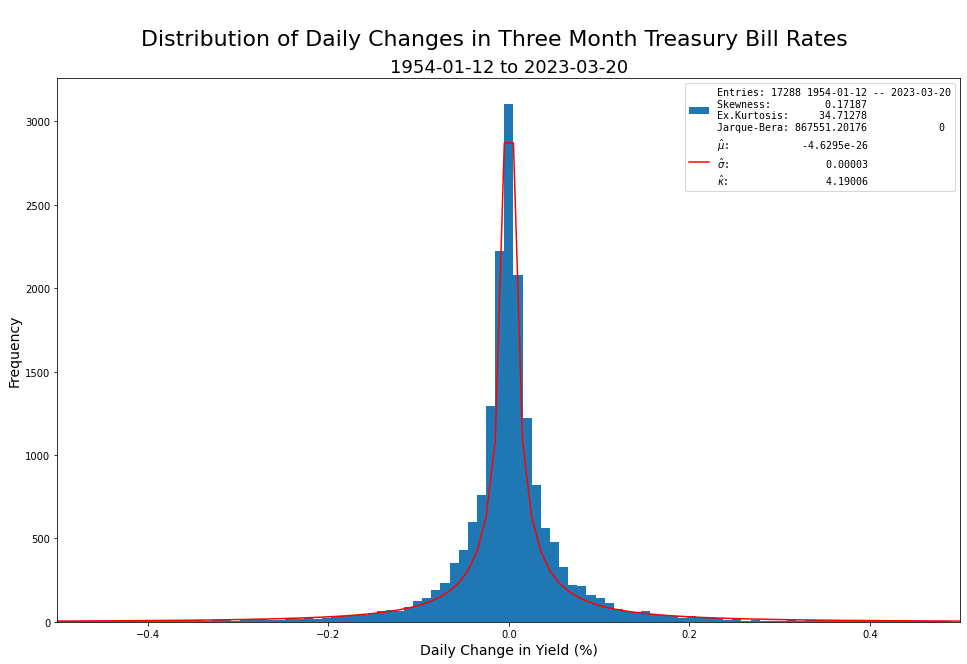

In [172]:
from scipy.stats import jarque_bera,gennorm # gennorm is parameterized in such a manner that kappa=1/beta and sigma=scale/(2^kappa)
DTB3['Change']=DTB3['Rate']-DTB3['Rate'].shift().ffill() # changes that skip over holidays, why is this so hard?
DTB3.dropna(inplace=True)
jbtest=jarque_bera(DTB3['Change'])
display(DTB3)

# Figure 2.15
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nDistribution of Daily Changes in Three Month Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
xmin,xmax=-half,half
estimates=gennorm.fit(DTB3['Change'])
model=gennorm(*estimates)
samples,bins,patches=plot.hist(DTB3['Change'],bins=np.linspace(xmin,xmax,100),label="""Entries: %d %s -- %s
Skewness:    %12.5f
Ex.Kurtosis: %12.5f
Jarque-Bera: %12.5f %12.5g""" % (
    DTB3["Change"].count(),DTB3.index[0],DTB3.index[-1],
    DTB3["Change"].skew(),
    DTB3["Change"].kurt(),
    jbtest.statistic,jbtest.pvalue
))
plot.plot(bins,model.pdf(bins)*sum(samples)*(bins[-1]-bins[0])/len(bins),'-r',label="""$\\hat{\\mu}$:           %12.5g
$\\hat{\\sigma}$:           %12.5f
$\\hat{\\kappa}$:           %12.5f""" % (estimates[-2],estimates[-1]/np.power(two,estimates[0]),one/estimates[0]))
plot.set_xlabel("Daily Change in Yield (%)",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
plot.set_xlim(xmin,xmax)
plot.legend(fontsize=18,prop={'family':'monospace'});

Optimization terminated successfully    (Exit mode 0)
            Current function value: 47781.33771473891
            Iterations: 35
            Function evaluations: 355
            Gradient evaluations: 35
                                AR-X - GARCH Model Results                                
Dep. Variable:                             Change   R-squared:                      -0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.000
Vol Model:                                  GARCH   Log-Likelihood:               -47781.3
Distribution:      Generalized Error Distribution   AIC:                           95576.7
Method:                        Maximum Likelihood   BIC:                           95631.0
                                                    No. Observations:                17287
Date:                            Wed, Mar 22 2023   Df Residuals:                    17284
Time:                                    19:18:19   Df Model: 

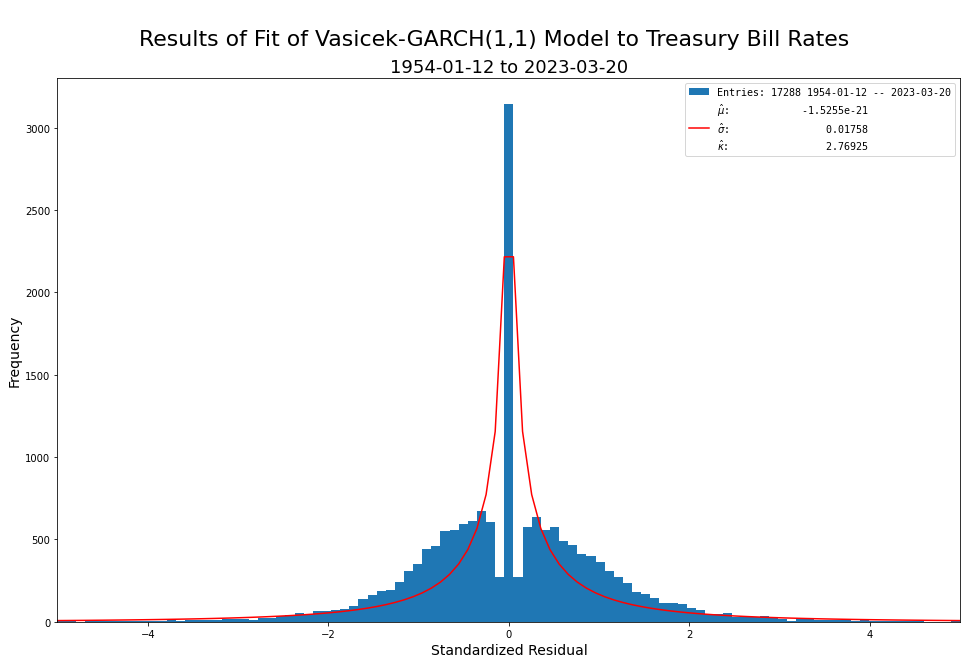

In [173]:
from arch.univariate import ARX, GARCH, GeneralizedError

model = ARX(DTB3["Change"]*hundred,DTB3['Rate'].shift().ffill()*hundred,lags=1) # in bp because arch whines about scaling --- bizarre but true
model.volatility = GARCH(1,0,1)
model.distribution = GeneralizedError()
fit=model.fit(update_freq=0)
print(fit.summary())
DTB3["Volatility"]=fit.conditional_volatility/hundred
DTB3["Innovations"]=DTB3["Change"]/DTB3["Volatility"]

# Figure 2.16
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nResults of Fit of Vasicek-GARCH(1,1) Model to Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
xmin,xmax=-five,five
estimates=gennorm.fit(DTB3['Innovations'].dropna())
model=gennorm(*estimates)
samples,bins,patches=plot.hist(DTB3['Innovations'],bins=np.linspace(xmin,xmax,100),label="""Entries: %d %s -- %s""" % (
    DTB3["Change"].count(),DTB3.index[0],DTB3.index[-1],
))
plot.plot(bins,model.pdf(bins)*sum(samples)*(bins[-1]-bins[0])/len(bins),'-r',label="""$\\hat{\\mu}$:           %12.5g
$\\hat{\\sigma}$:           %12.5f
$\\hat{\\kappa}$:           %12.5f""" % (estimates[-2],estimates[-1]/np.power(two,estimates[0]),one/estimates[0]))
plot.set_xlabel("Standardized Residual",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
plot.set_xlim(xmin,xmax)
plot.legend(fontsize=18,prop={'family':'monospace'});